In [348]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib


# Import MNE processing
from mne_nirs.statistics import statsmodels_to_results, run_glm

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import matplotlib as mpl
from mne.stats import fdr_correction


# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools
import glm_analysis
import visualizations

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)
importlib.reload(glm_analysis)
importlib.reload(visualizations)

<module 'visualizations' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py'>

In [332]:
# ------------------------------------------------------------------
# Recurring values that we will allow for users to change in the GUI
# ------------------------------------------------------------------

# Length of the measured interval
interval_length = 50

# Time from trigger point being evaluated
tmin = -1
tmax = 50

# Does the study have variable task lengths or does the study follow a block design?
variable_epoch_time = False





In [333]:
# # FV Study Parameters
ignore = [".DS_Store", ".git", "sub-18", "sub-14", ".gitignore"]
columns_for_group_analysis = ['Neutral', 'Concern']
columns_for_glm_contrast = ['Neutral', 'Concern']
path = '../../FV_Prelim_Data/'
trigger_id = {'1': 'Start', '2': 'Neutral', '3': 'Concern'}
columns_for_fdr = ['Neutral', 'Concern']

In [334]:
# FA Study Parameters
# columns_for_group_analysis = ['Neutral', 'Inflam', 'Control']
# columns_for_glm_contrast = ['Neutral', 'Inflam', 'Control']
# columns_for_fdr = ['Control', 'Inflam']
# path = "../../LabResearch/IndependentStudy/Data/FA"
# ignore = [".DS_Store", "sub-03", ".git", ".gitignore"]
# trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflam', '1':'Practice'}

In [335]:
# Oculus Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/oculus_montage_bids/'
# ignore = [".DS_Store", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

In [336]:
# N-Back Control Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/n-back-bids/'
# ignore = [".DS_Store", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

In [337]:
# Live Drive
# ignore = [".DS_Store", ".git", "sub-01", ".gitignore"]
# columns_for_group_analysis = ['Driving']
# columns_for_glm_contrast = ['Driving']
# path = '../../LiveDrive'
# trigger_id = {'2': 'Driving'}
# columns_for_fdr = ['Driving']

In [338]:
# VR Driving
# ignore = [".DS_Store", ".git", ".gitignore"]
# columns_for_group_analysis = ['Driving']
# columns_for_glm_contrast = ['Driving']
# path = '../../Drive_VR/'
# trigger_id = {'2': 'Driving'}
# columns_for_fdr = ['Driving']

In [339]:
# Live Drive w/ Pause
# ignore = [".DS_Store", ".git", ".gitignore"]
# columns_for_group_analysis = ['Driving']
# columns_for_glm_contrast = ['Driving']
# path = '../../Driving_with_pause/'
# trigger_id = {'2': 'Driving'}
# columns_for_fdr = ['Driving']

In [340]:

def run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    # Establish the groups, subject names, and snirf file paths for all subjects
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}
    for group in groups:
        paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()

        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time, tmin=tmin, tmax=tmax)
        
        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)
        print("GLM Data Processed ---> Calcuating GLM Dataframe")
        
        # Converts the glm design matrixes into a dataframe
        df_cha, df_con, glm_results = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        raw_haemo = all_data[0]['raw_haemo']
        
        print("GLM Dataframe Generated. Finding all significant channels")
        # Find the groups significant channels
        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[group] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results

In [341]:
def run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}

    paths = df[df.any(1)]['snirf_path'].to_numpy()

    for id, path in enumerate(paths):
        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=[path], trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)
        
        raw_haemo = all_data[0]['raw_haemo']

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con, glm_results = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[f'sub-{id+1}'] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results

In [342]:
importlib.reload(analysis_tools)
importlib.reload(glm_analysis)
group_data, all_epochs, all_evokeds, glm_results = run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=tmin, tmax=tmax, trigger_id=trigger_id)

print(glm_results)


Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-13/nirs/2023-03-09_001.snirf
Reading 0 ... 9146  =      0.000 ...   899.052 secs...
[[ 34   0   3]
 [ 38   0   2]
 [ 66   0   2]
 [ 94   0   1]
 [122   0   1]
 [150   0   1]
 [177   0   1]
 [205   0   2]
 [233   0   1]
 [261   0   1]
 [289   0   2]
 [317   0   2]
 [345   0   1]
 [373   0   1]
 [401   0   2]
 [429   0   2]
 [457   0   1]
 [485   0   2]
 [513   0   2]
 [541   0   2]
 [569   0   2]
 [597   0   1]
 [625   0   1]
 [654   0   1]
 [681   0   2]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-15/nirs/2023-03-22_005.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 8796  =      0.000 ...   864.647 secs...
[[  9   0   3]
 [ 13   0   2]
 [ 41   0   2]
 [ 69   0   1]
 [ 97   0   1]
 [125   0   1]
 [153   0   1]
 [181   0   2]
 [209   0   1]
 [237   0   2]
 [265   0   2]
 [293   0   2]
 [321   0   1]
 [349   0   1]
 [377   0   1]
 [405   0   1]
 [433   0   2]
 [461   0   1]
 [489   0   1]
 [517   0   2]
 [545   0   2]
 [573   0   2]
 [601   0   2]
 [629   0   2]
 [657   0   1]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-12/nirs/2023-02-10_003.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 8750  =      0.000 ...   860.125 secs...
[[  8   0   3]
 [ 12   0   1]
 [ 40   0   1]
 [ 68   0   2]
 [ 96   0   1]
 [124   0   2]
 [152   0   1]
 [180   0   1]
 [208   0   2]
 [236   0   2]
 [264   0   2]
 [292   0   1]
 [320   0   1]
 [348   0   1]
 [376   0   1]
 [404   0   1]
 [432   0   1]
 [460   0   2]
 [488   0   1]
 [516   0   2]
 [544   0   2]
 [572   0   2]
 [600   0   2]
 [628   0   2]
 [656   0   2]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-08/nirs/2023-02-17_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 9088  =      0.000 ...   893.350 secs...
[[ 26   0   3]
 [ 30   0   2]
 [ 58   0   2]
 [ 86   0   1]
 [114   0   2]
 [142   0   1]
 [170   0   2]
 [198   0   2]
 [226   0   1]
 [254   0   1]
 [282   0   1]
 [310   0   2]
 [338   0   1]
 [366   0   2]
 [394   0   1]
 [422   0   2]
 [450   0   1]
 [478   0   1]
 [506   0   2]
 [534   0   2]
 [562   0   2]
 [590   0   2]
 [618   0   1]
 [646   0   1]
 [674   0   1]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-01/nirs/2023-02-17_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 8713  =      0.000 ...   856.488 secs...
[[  6   0   3]
 [ 10   0   1]
 [ 38   0   2]
 [ 66   0   1]
 [ 94   0   2]
 [122   0   1]
 [150   0   2]
 [178   0   2]
 [206   0   1]
 [234   0   1]
 [262   0   2]
 [290   0   1]
 [318   0   1]
 [346   0   2]
 [374   0   1]
 [402   0   2]
 [430   0   2]
 [458   0   2]
 [486   0   1]
 [514   0   1]
 [542   0   1]
 [570   0   2]
 [598   0   2]
 [626   0   2]
 [654   0   1]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-06/nirs/2023-02-10_004.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 9282  =      0.000 ...   912.421 secs...
[[ 43   0   3]
 [ 47   0   1]
 [ 75   0   1]
 [103   0   2]
 [131   0   2]
 [159   0   1]
 [187   0   1]
 [215   0   2]
 [243   0   1]
 [271   0   2]
 [299   0   1]
 [327   0   2]
 [355   0   2]
 [383   0   2]
 [411   0   1]
 [439   0   1]
 [467   0   2]
 [495   0   2]
 [523   0   2]
 [551   0   2]
 [579   0   1]
 [607   0   1]
 [635   0   1]
 [663   0   2]
 [691   0   1]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-07/nirs/2023-02-17_001.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 9460  =      0.000 ...   929.918 secs...
[[ 50   0   3]
 [ 54   0   2]
 [ 82   0   1]
 [110   0   1]
 [138   0   1]
 [166   0   2]
 [194   0   2]
 [222   0   2]
 [250   0   1]
 [278   0   1]
 [306   0   1]
 [334   0   2]
 [362   0   1]
 [390   0   1]
 [418   0   1]
 [446   0   2]
 [474   0   2]
 [502   0   2]
 [530   0   2]
 [558   0   2]
 [586   0   1]
 [614   0   2]
 [642   0   1]
 [670   0   1]
 [698   0   2]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-09/nirs/2023-03-01_004.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 13102  =      0.000 ...  1287.927 secs...
[[347   0   3]
 [351   0   2]
 [379   0   2]
 [407   0   1]
 [435   0   2]
 [463   0   1]
 [491   0   2]
 [519   0   2]
 [547   0   2]
 [575   0   1]
 [603   0   1]
 [631   0   2]
 [659   0   1]
 [687   0   1]
 [715   0   2]
 [743   0   2]
 [771   0   2]
 [799   0   1]
 [827   0   2]
 [855   0   2]
 [883   0   1]
 [911   0   1]
 [939   0   1]
 [967   0   1]
 [995   0   1]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-17/nirs/2023-03-22_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 11307  =      0.000 ...  1111.478 secs...
[[205   0   3]
 [209   0   2]
 [237   0   1]
 [265   0   1]
 [293   0   1]
 [321   0   2]
 [349   0   2]
 [377   0   2]
 [405   0   2]
 [433   0   1]
 [461   0   2]
 [489   0   2]
 [517   0   2]
 [545   0   1]
 [573   0   1]
 [601   0   2]
 [629   0   1]
 [657   0   2]
 [685   0   1]
 [713   0   1]
 [741   0   1]
 [769   0   2]
 [797   0   1]
 [825   0   1]
 [853   0   2]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-10/nirs/2023-03-08_001.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 11040  =      0.000 ...  1085.232 secs...
[[182   0   3]
 [186   0   2]
 [214   0   1]
 [242   0   1]
 [270   0   1]
 [298   0   1]
 [326   0   2]
 [354   0   1]
 [382   0   2]
 [410   0   2]
 [438   0   1]
 [466   0   2]
 [494   0   2]
 [522   0   1]
 [550   0   1]
 [578   0   1]
 [606   0   2]
 [634   0   2]
 [662   0   1]
 [690   0   2]
 [718   0   1]
 [746   0   2]
 [774   0   1]
 [802   0   2]
 [830   0   2]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-19/nirs/2023-03-23_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 9278  =      0.000 ...   912.027 secs...
[[ 45   0   3]
 [ 49   0   1]
 [ 77   0   2]
 [105   0   2]
 [133   0   1]
 [161   0   1]
 [189   0   1]
 [217   0   2]
 [245   0   1]
 [273   0   2]
 [301   0   2]
 [329   0   2]
 [357   0   1]
 [385   0   2]
 [413   0   2]
 [441   0   2]
 [469   0   1]
 [497   0   1]
 [525   0   2]
 [553   0   2]
 [581   0   2]
 [609   0   1]
 [637   0   1]
 [665   0   1]
 [693   0   1]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-11/nirs/2023-02-10_001.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 10100  =      0.000 ...   992.830 secs...
[[112   0   3]
 [116   0   1]
 [144   0   1]
 [172   0   1]
 [200   0   2]
 [228   0   2]
 [256   0   2]
 [284   0   2]
 [312   0   2]
 [340   0   2]
 [368   0   1]
 [396   0   1]
 [424   0   1]
 [452   0   1]
 [480   0   1]
 [508   0   2]
 [536   0   1]
 [564   0   2]
 [592   0   2]
 [620   0   2]
 [648   0   1]
 [676   0   1]
 [704   0   1]
 [732   0   2]
 [760   0   2]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-16/nirs/2023-03-22_001.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 9757  =      0.000 ...   959.113 secs...
[[ 82   0   3]
 [ 86   0   2]
 [114   0   2]
 [142   0   1]
 [170   0   1]
 [198   0   1]
 [226   0   2]
 [254   0   1]
 [282   0   2]
 [310   0   1]
 [338   0   2]
 [366   0   1]
 [394   0   2]
 [422   0   1]
 [450   0   1]
 [478   0   1]
 [506   0   2]
 [534   0   2]
 [562   0   1]
 [590   0   2]
 [618   0   1]
 [646   0   2]
 [674   0   1]
 [702   0   2]
 [730   0   2]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-05/nirs/2023-02-10_003.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 9566  =      0.000 ...   940.338 secs...
[[ 61   0   3]
 [ 65   0   2]
 [ 93   0   1]
 [121   0   1]
 [149   0   1]
 [177   0   1]
 [205   0   2]
 [233   0   1]
 [261   0   1]
 [289   0   1]
 [317   0   2]
 [345   0   1]
 [373   0   2]
 [401   0   2]
 [429   0   2]
 [457   0   2]
 [485   0   2]
 [513   0   2]
 [541   0   2]
 [569   0   2]
 [597   0   2]
 [625   0   1]
 [653   0   1]
 [681   0   1]
 [709   0   1]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-02/nirs/2023-02-23_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 8780  =      0.000 ...   863.074 secs...
[[  8   0   3]
 [ 12   0   1]
 [ 40   0   2]
 [ 68   0   1]
 [ 96   0   2]
 [124   0   1]
 [152   0   1]
 [180   0   2]
 [208   0   1]
 [236   0   1]
 [264   0   2]
 [292   0   2]
 [320   0   2]
 [348   0   2]
 [376   0   1]
 [404   0   2]
 [432   0   1]
 [460   0   1]
 [488   0   2]
 [516   0   2]
 [544   0   2]
 [572   0   1]
 [600   0   1]
 [628   0   2]
 [656   0   1]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-03/nirs/2023-02-10_001.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 9439  =      0.000 ...   927.854 secs...
[[ 53   0   3]
 [ 57   0   1]
 [ 85   0   2]
 [113   0   1]
 [141   0   1]
 [169   0   2]
 [197   0   2]
 [225   0   2]
 [253   0   1]
 [281   0   2]
 [309   0   1]
 [337   0   2]
 [365   0   1]
 [393   0   1]
 [421   0   2]
 [449   0   2]
 [477   0   2]
 [505   0   1]
 [533   0   1]
 [561   0   2]
 [589   0   2]
 [617   0   1]
 [645   0   2]
 [673   0   1]
 [701   0   1]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-04/nirs/2023-02-10_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 8961  =      0.000 ...   880.866 secs...


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


[[ 18   0   3]
 [ 22   0   1]
 [ 50   0   2]
 [ 78   0   2]
 [106   0   1]
 [134   0   1]
 [162   0   1]
 [190   0   1]
 [218   0   2]
 [246   0   2]
 [274   0   2]
 [302   0   1]
 [330   0   1]
 [358   0   1]
 [386   0   2]
 [414   0   1]
 [442   0   1]
 [470   0   1]
 [498   0   1]
 [526   0   2]
 [554   0   2]
 [582   0   2]
 [610   0   2]
 [638   0   2]
 [666   0   2]] {'Concern': 1, 'Neutral': 2, 'Start': 3}
GLM Data Processed ---> Calcuating GLM Dataframe
Columns in Design matrix Index(['Concern', 'Neutral', 'Start', 'drift_1', 'drift_2', 'drift_3',
       'drift_4', 'drift_5', 'drift_6', 'drift_7', 'drift_8', 'drift_9',
       'drift_10', 'drift_11', 'drift_12', 'drift_13', 'drift_14', 'drift_15',
       'drift_16', 'drift_17', 'constant'],
      dtype='object')
Columns in Design matrix Index(['Concern', 'Neutral', 'Start', 'drift_1', 'drift_2', 'drift_3',
       'drift_4', 'drift_5', 'drift_6', 'drift_7', 'drift_8', 'drift_9',
       'drift_10', 'drift_11', 'drift_12', 'drift_1

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


GLM Results for 36 channels


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sig_channels = all_sig_channels.append(sig_df)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sig_channels = all_sig_channels.append(sig_df)


In [343]:
# individual_data, all_epochs, all_evokeds = run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, trigger_id)
# individual_data

# Visualizations

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[vals] = model_data[vals].astype(float)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

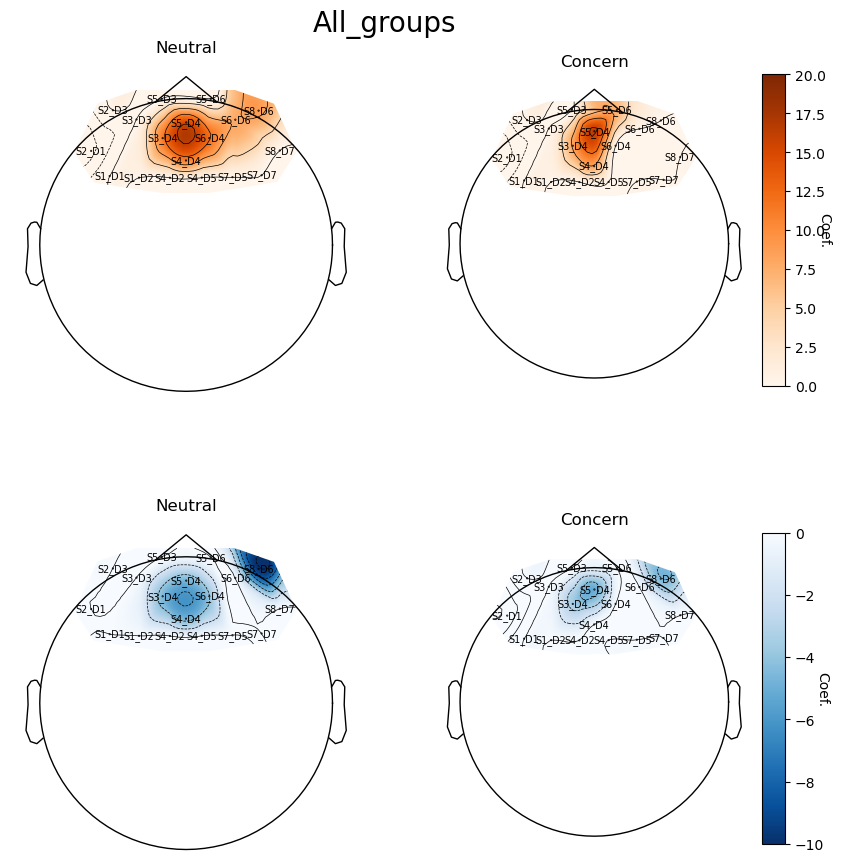

In [344]:
# Group Visualization
importlib.reload(visualizations)
groups = list(group_data.keys())
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()
    raw_haemo = all_data[0]['raw_haemo']
    visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo, group)

In [351]:
# Group Visualization with FDR Correction
importlib.reload(visualizations)
importlib.reload(analysis_tools)
ignored_vals = ['drift', 'Start', 'constant']

groups = list(group_data.keys())
results = {}
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

    channels_df_fdr = analysis_tools.false_discovery_rate_correction(channels_df, ignored_vals, columns_for_fdr)

    raw_haemo = all_data[0]['raw_haemo']

    alpha = 0.05
    p_vals = channels_df['p_value']
    reject_fdr, pval_fdr = fdr_correction(p_vals, alpha=alpha, method='indep')
    channels_df['fdr_status'] = reject_fdr
    channels_df_fdr = channels_df.loc[(channels_df['fdr_status'] == True) & (~channels_df['Condition'].isin(ignored_vals))]
    channels_df_fdr = channels_df_fdr.drop_duplicates()
    print(channels_df_fdr)
    channels_df_fdr.to_csv('FV_results_FDR.csv')
    
    # channels_df_fdr.to_csv('channels_df_fdr.csv')
    # visualizations.group_topological_visualisation(channels_df_fdr, columns_for_glm_contrast, raw_haemo, group)

variable Condition    df           mse   p_value            se         t  \
4768       Neutral  21.0  3.949961e-12  0.000007  6.879842e-07  5.931251   
5146       Neutral  21.0  4.394964e-13  0.000007  2.294878e-07 -5.931251   
34662      Concern  21.0  2.888732e-12  0.000010  6.028842e-07  5.751643   
35040      Concern  21.0  3.850156e-13  0.000010  2.200997e-07 -5.751643   

variable     theta Source Detector Chroma  Significant    ch_name  ID  \
4768      0.000004      5        6    hbo         True  S5_D6 hbo  12   
5146     -0.000001      5        6    hbr         True  S5_D6 hbr  12   
34662     0.000003      5        4    hbo         True  S5_D4 hbo   2   
35040    -0.000001      5        4    hbr         True  S5_D4 hbr   2   

variable  fdr_status  
4768            True  
5146            True  
34662           True  
35040           True  


In [ ]:
# # Group Cortical Projections
# importlib.reload(visualizations)
# groups = list(group_data.keys())
# for group in groups:
#     # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
#     channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

#     raw_haemo = all_data[0]['raw_haemo']
#     visualizations.group_cortical_surface_projection(channels_df, columns_for_glm_contrast, raw_haemo, path)

[<Evoked | 'Concern' (average, N=12), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Concern' (average, N=11), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Concern' (average, N=12), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Concern' (average, N=11), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Concern' (average, N=11), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Concern' (average, N=11), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Concern' (average, N=12), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Concern' (average, N=11), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Concern' (average, N=12), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Concern' (average, N=12), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'Concern' (average, N=11), -1.25 – 50 sec, baseli

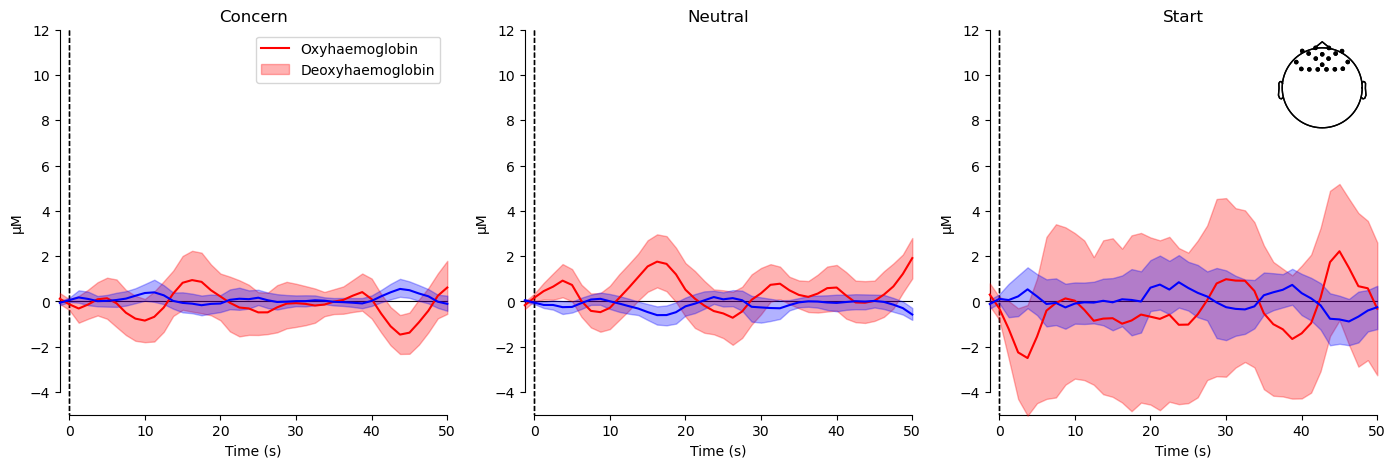

In [346]:
importlib.reload(visualizations)
visualizations.plot_waveform_analysis(all_evokeds, variable_epoch_time)

In [ ]:
# Individual Visualization
# importlib.reload(visualizations)
# if individual_data:
#     channels_df, contrasts_df, significant_channels, all_data = individual_data['sub-1'].values()

#     raw_haemo = all_data[0]['raw_haemo']

#     visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

# Export Results

In [347]:
# Download the Results
keys = list(group_data.keys())
complete_results = pd.DataFrame()
for key in keys:
    sig_cha = group_data[key]['significant_channels']
    print(sig_cha)
    sig_cha['group'] = key
    complete_results = pd.concat([complete_results, sig_cha])
    complete_results['Coef.'] = complete_results['Coef.'] * 1e6
complete_results.to_csv('FV_results.csv')

                            Coef. Std.Err.         z         P>|z|    [0.025  \
ch_name   Condition                                                            
S2_D1 hbo Concern   -9.040275e-07      0.0 -2.750068  5.958299e-03 -0.000002   
          Neutral   -8.999443e-07      0.0 -2.737646  6.188058e-03 -0.000002   
S3_D4 hbo Concern    8.463504e-07      0.0  2.574613  1.003524e-02       0.0   
          Neutral    1.123546e-06      0.0  3.417848  6.311838e-04       0.0   
S4_D4 hbo Concern    7.749630e-07      0.0  2.357451  1.840088e-02       0.0   
          Neutral    1.034470e-06      0.0  3.146876  1.650251e-03       0.0   
S5_D4 hbo Concern    1.647227e-06      0.0  5.010894  5.417776e-07  0.000001   
          Neutral    1.566249e-06      0.0  4.764557  1.892691e-06  0.000001   
S5_D6 hbo Concern    7.118386e-07      0.0  2.165425  3.035512e-02       0.0   
S6_D4 hbo Neutral    1.227729e-06      0.0  3.734774  1.878836e-04  0.000001   
S6_D6 hbo Neutral    7.802244e-07      0